# Model Analysis

In [1]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import time
from datetime import datetime

C:\Users\acer\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Data load from Excel
file_path = 'Aditya Birla Sun Life Liquid Fund-Retail (Growth).xlsx'  
df = pd.read_excel(file_path)
# Reverse the DataFrame - to make it from old to new
df = df[::-1]
df

,date,nav
3890,01-01-2012,275.7253
3889,02-01-2012,275.7907
3888,03-01-2012,275.8576
3887,04-01-2012,275.9239
3886,05-01-2012,275.9909
...,...,...
4,15-04-2024,628.0995
3,16-04-2024,628.2255
2,17-04-2024,628.3417
1,18-04-2024,628.4563


### Visualising

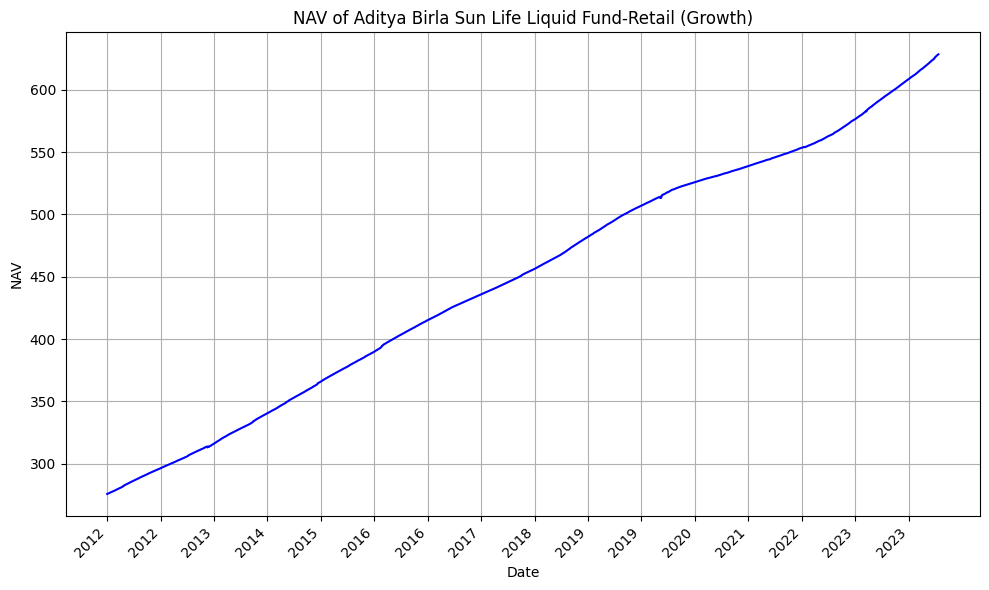

In [3]:
# Extract year from date
df['year'] = pd.to_datetime(df['date'], format='%d-%m-%Y').dt.year

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['nav'], color='blue', linestyle='-')
plt.title('NAV of Aditya Birla Sun Life Liquid Fund-Retail (Growth)')
plt.xlabel('Date')
plt.ylabel('NAV')
plt.xticks(df['date'][::250], df['year'][::250], rotation=45, ha='right')  # Show year labels every 250th data point
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.grid(True)
plt.show()

Time series data in the context of mutual funds' NAV (Net Asset Value) values refers to the historical record of NAV values over time. Each NAV value, recorded at successive points in time, establishes a chronological order. Trends in NAV values indicate the fund's overall movement—whether it's increasing, decreasing, or staying stable. While mutual funds' NAV values may not exhibit traditional seasonal patterns, they can still show periodic fluctuations influenced by market cycles or economic conditions. Additionally, cyclic patterns may arise from broader economic cycles or sector-specific dynamics. Random variations in NAV values reflect day-to-day fluctuations driven by market volatility or investor sentiment. Understanding NAV time series data is crucial for investors, fund managers, and analysts to assess performance, make investment decisions, and develop forecasting models.

#### Train test split creation

In [4]:
# Split the data into features (X) and target variable (y)
X = df.drop(columns=['nav'])  # Since 'date' is the only feature
y = df['nav']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # Adjust test_size as needed

# Optionally, you can print the shapes of the resulting datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (3112, 2) (3112,)
Testing set shape: (779, 2) (779,)


## Model Analysis

In [5]:
# Function to calculate evaluation metrics
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse


### ARIMA

ARIMA stands for Autoregressive Integrated Moving Average. It's a popular method for time series forecasting. ARIMA combines three elements:

Autoregressive (AR): It looks at the relationship between current and past observations.
Integrated (I): It makes the time series stationary by differencing.
Moving Average (MA): It considers the relationship between an observation and a residual error from a moving average model.

ARIMA models are defined by three parameters: p, d, and q, which represent the order of AR, differencing, and MA respectively. They're used in various fields to forecast future values based on past data patterns.

In [6]:
# Function to fit and evaluate ARIMA model
def fit_arima(X_train, y_train, X_test):
    model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    start_time = time.time()
    model_fit = model.fit()
    end_time = time.time()
    y_pred = model_fit.forecast(steps=len(X_test))
    return y_pred, end_time - start_time

### SARIMA

SARIMA, or Seasonal Autoregressive Integrated Moving Average, is an extension of the ARIMA model that takes into account seasonal patterns in time series data. It combines the core ARIMA components with seasonal elements.

Seasonal Autoregressive (SAR): Like the AR term in ARIMA, SARIMA includes a seasonal autoregressive component that captures the relationship between the current observation and past observations at the same seasonality lag.

Integrated (I): Similar to ARIMA, SARIMA includes differencing to make the time series stationary.

Seasonal Moving Average (SMA): This component captures the relationship between an observation and a residual error from a moving average model applied to past seasonal observations.

SARIMA models are specified by additional parameters: P, D, Q, and m, representing the seasonal order of autoregression, differencing, moving average, and the length of the seasonal cycle respectively. These models are useful for forecasting time series data that exhibit seasonal patterns or fluctuations.

In [7]:
# Function to fit and evaluate SARIMA model
def fit_sarima(X_train, y_train, X_test):
    model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    start_time = time.time()
    model_fit = model.fit()
    end_time = time.time()
    y_pred = model_fit.forecast(steps=len(X_test))
    return y_pred, end_time - start_time

### ETS

The ETS (Error, Trend, Seasonality) model, also known as the Exponential Smoothing State Space model, is a class of forecasting methods that captures the underlying structure of time series data by decomposing it into three main components:

Error (E): Represents the random noise or irregular component of the time series, which is assumed to be a random variable with mean zero.

Trend (T): Captures the long-term movement or directionality in the time series data. It can be additive, where changes over time occur at a constant rate, or multiplicative, where changes over time occur at a varying rate.

Seasonality (S): Accounts for repeating patterns or fluctuations that occur at fixed intervals within the time series data, such as daily, weekly, or monthly cycles.

The ETS model uses exponential smoothing to estimate the current value of the time series based on its historical values and the estimated values of the error, trend, and seasonality components. It is characterized by parameters that control the smoothing process for each component, such as alpha (α) for the level (error), beta (β) for the trend, and gamma (γ) for the seasonality.

ETS models are particularly useful for short-term forecasting and are commonly applied in business forecasting scenarios where time series data exhibit trend and seasonal patterns. They provide a flexible framework for capturing various types of time series behavior while requiring minimal computational resources

In [8]:
# Function to fit and evaluate ETS model
def fit_ets(X_train, y_train, X_test):
    model = ExponentialSmoothing(y_train)
    start_time = time.time()
    model_fit = model.fit()
    end_time = time.time()
    y_pred = model_fit.forecast(steps=len(X_test))
    return y_pred, end_time - start_time

### LSTM (Long Short-Term Memory)

LSTM (Long Short-Term Memory) is a type of neural network designed to process and predict sequences of data while retaining information over long periods. It addresses the vanishing gradient problem of traditional RNNs, making it effective for tasks like language translation, speech recognition, and time series forecasting. Its architecture includes memory cells with gates that control the flow of information, allowing it to capture long-term dependencies in sequential data.

In [9]:
def fit_lstm(X_train, y_train, X_test):
    # Convert date strings to timestamps
    reference_date = datetime(1970, 1, 1)  # Reference date for Unix epoch
    
    X_train_timestamps = X_train['date'].apply(lambda x: (datetime.strptime(x, '%d-%m-%Y') - reference_date).total_seconds())
    X_train_reshaped = np.array(X_train_timestamps).reshape(-1, 1, 1)
    
    X_test_timestamps = X_test['date'].apply(lambda x: (datetime.strptime(x, '%d-%m-%Y') - reference_date).total_seconds())
    X_test_reshaped = np.array(X_test_timestamps).reshape(-1, 1, 1)
    
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
    
    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(1, 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Fit the LSTM model
    start_time = time.time()
    model.fit(X_train_reshaped, y_train_scaled, epochs=100, batch_size=1, verbose=0)
    end_time = time.time()
    
    # Predict using the trained model
    y_pred_scaled = model.predict(X_test_reshaped)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    return y_pred.flatten(), end_time - start_time

### Prophet

The technique behind Prophet involves decomposing time series data into several components: trend, seasonality (daily, weekly, yearly), holiday effects, and error term. It utilizes a generalized additive model (GAM) framework, where the time series is modeled as the sum of these components, along with additional parameters that control their flexibility and impact.

Prophet uses a piecewise linear or logistic growth curve for the trend, allowing for changes in growth rates over time. Seasonality is modeled using Fourier series, which can capture periodic patterns at different frequencies. Holiday effects are accounted for by including indicator variables for specific holidays.

To estimate the parameters of the model, Prophet uses a Markov Chain Monte Carlo (MCMC) sampling method or optimization algorithms. This allows for uncertainty estimation and provides confidence intervals around the forecasted values.

Overall, Prophet combines various statistical techniques and heuristics to provide robust and flexible time series forecasting capabilities, especially suited for datasets with seasonal patterns and irregularities.

In [10]:
# Function to fit and evaluate Prophet model
def fit_prophet(X_train, y_train, X_test):
    # Step 1: Prepare training data
    train_df = pd.DataFrame({'ds': pd.to_datetime(X_train['date'], format='%d-%m-%Y'), 'y': y_train})
    # Step 2: Prepare test data
    test_df = pd.DataFrame({'ds': pd.to_datetime(X_test['date'], format='%d-%m-%Y')})
    model = Prophet()
    start_time = time.time()
    model.fit(train_df)
    future = model.make_future_dataframe(periods=len(X_test))
    forecast = model.predict(future)
    end_time = time.time()
    y_pred = forecast['yhat'].values[-len(X_test):]
    return y_pred, end_time - start_time


### GBM (Gradient Boosting Machine) 

GBM (Gradient Boosting Machine) is a machine learning method that combines multiple weak learners (often decision trees) sequentially to improve prediction accuracy. It works by iteratively correcting errors made by the previous models. Through gradient descent optimization, it minimizes a loss function by fitting new models to the negative gradient of the loss. GBM is known for its high accuracy and robustness against overfitting

In [11]:
def preprocess_dates(date_strings):
    timestamps = pd.to_datetime(date_strings['date'], format='%d-%m-%Y')
    return timestamps

# Function to fit and evaluate GBM model
def fit_gbm(X_train, y_train, X_test):
    
    # Preprocess date strings into numerical timestamps
    X_train_timestamps = preprocess_dates(X_train)
    X_test_timestamps = preprocess_dates(X_test)
    
    model = GradientBoostingRegressor()
    start_time = time.time()
    model.fit(np.array(X_train_timestamps).reshape(-1, 1), y_train)
    end_time = time.time()
    y_pred = model.predict(np.array(X_test_timestamps).reshape(-1, 1))
    
    return y_pred, end_time - start_time

## Evaluating Models

In [12]:
# Fit and evaluate models
models = {
    'ARIMA': fit_arima,
    'SARIMA': fit_sarima,
    'ETS': fit_ets,
    'LSTM': fit_lstm,
    'Prophet': fit_prophet,
    'GBM': fit_gbm
}

results = {}
for model_name, model_func in models.items():
    print(f"Fitting and evaluating {model_name}...")
    y_pred, execution_time = model_func(X_train, y_train, X_test)
    mae, mse, rmse = evaluate(y_test, y_pred)
    results[model_name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'Execution Time (s)': execution_time
    }

# Print results
print("\nModel Comparison Results:")
results_df = pd.DataFrame(results)
print(results_df)

Fitting and evaluating ARIMA...


C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWar

Fitting and evaluating SARIMA...


C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\acer\anaconda3\lib\site-packages\statsmodels\tsa

Fitting and evaluating ETS...
Fitting and evaluating LSTM...
25/25 [==============================] - 0s 1ms/step
Fitting and evaluating Prophet...


20:26:05 - cmdstanpy - INFO - Chain [1] start processing
20:26:07 - cmdstanpy - INFO - Chain [1] done processing


Fitting and evaluating GBM...

Model Comparison Results:
                         ARIMA      SARIMA          ETS          LSTM  \
MAE                  12.523221   12.523221    35.084026  4.725328e+03   
MSE                 302.824595  302.824595  1849.498018  2.248736e+07   
RMSE                 17.401856   17.401856    43.005791  4.742084e+03   
Execution Time (s)    7.786176    7.891894     0.008977  3.166486e+02   

                       Prophet          GBM  
MAE                  13.943275    35.388145  
MSE                 371.871556  1870.929991  
RMSE                 19.283971    43.254248  
Execution Time (s)    2.638968     0.318149  


In [13]:
results_df

,ARIMA,SARIMA,ETS,LSTM,Prophet,GBM
MAE,12.523221,12.523221,35.084026,4.725328e+03,13.943275,35.388145
MSE,302.824595,302.824595,1849.498018,2.248736e+07,371.871556,1870.929991
RMSE,17.401856,17.401856,43.005791,4.742084e+03,19.283971,43.254248
Execution Time (s),7.786176,7.891894,0.008977,3.166486e+02,2.638968,0.318149


Lower values for MAE, MSE, and RMSE indicate better predictive performance, while lower execution time is desirable for efficiency.

Based on the comparison results:

ARIMA, SARIMA, Prophet: These models have relatively lower MAE, MSE, and RMSE compared to ETS and GBM, indicating better predictive performance in terms of accuracy.
ETS: This model has the highest MAE, MSE, and RMSE among all models, suggesting relatively poorer predictive performance compared to the others.
LSTM, GBM: These models have extremely high MAE, MSE, and RMSE compared to the other models, indicating significantly worse predictive performance.
In terms of execution time:

ETS has the fastest execution time, followed by Prophet and GBM.
ARIMA and SARIMA have relatively longer execution times.
LSTM has the longest execution time among all models.

#### Considering both predictive performance and execution time, it appears that Prophet performs relatively well, with moderate predictive performance and a relatively low execution time.

## END